# Concatonate all gene counts into one matrix

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
globbed_files = glob.glob('Data2/project*/*')
globbed_files

['Data2/project-ugd-hiv-pneu_host-gene-counts/ops015_ugd-hiv-pneu_bal_rna_1186_a4_s31_10421',
 'Data2/project-ugd-hiv-pneu_host-gene-counts/ops015_ugd-hiv-pneu_bal_rna_2195_f21_s160_10588',
 'Data2/project-ugd-hiv-pneu_host-gene-counts/ops015_ugd-hiv-pneu_bal_rna_1254_e6_s56_10430',
 'Data2/project-ugd-hiv-pneu_host-gene-counts/ops015_ugd-hiv-pneu_bal_rna_2192_b21_s136_10586',
 'Data2/project-ugd-hiv-pneu_host-gene-counts/ops015_ugd-hiv-pneu_bal_rna_1858_l3_s187_10520',
 'Data2/project-ugd-hiv-pneu_host-gene-counts/ops015_ugd-hiv-pneu_bal_rna_2321_j2_s17_10606',
 'Data2/project-ugd-hiv-pneu_host-gene-counts/ops015_ugd-hiv-pneu_bal_rna_1289_i6_s80_10432',
 'Data2/project-ugd-hiv-pneu_host-gene-counts/ops015_ugd-hiv-pneu_bal_rna_1864_n3_s199_10521',
 'Data2/project-ugd-hiv-pneu_host-gene-counts/ops015_ugd-hiv-pneu_bal_rna_1592_e16_s61_10470',
 'Data2/project-ugd-hiv-pneu_host-gene-counts/ops015_ugd-hiv-pneu_bal_rna_1829_p1_s210_10514',
 'Data2/project-ugd-hiv-pneu_host-gene-counts/ops015

In [3]:
data = []
frame = pd.read_csv(globbed_files[0], sep='\t', header = None)
data.append(frame[[0]]) # append gene names

# append gene values for all samples
for tsv in globbed_files:
    frame = pd.read_csv(tsv, sep='\t', header = None)
    data.append(frame[[1]])

    
bigframe = pd.concat(data, axis=1, ignore_index = True)
bigframe[[0,1,2,3,4,5,6]].head()

bigframe.index = bigframe[[0]]
bigframe[[0,1,2,3,4,5,6]].head()

new_idx = [tup[0] for tup in list(bigframe.index)]
bigframe.index = new_idx

bigframe.drop(0, axis=1, inplace=True)

gf = [i.split('/')[-1] for i in globbed_files]
bigframe.columns = gf

bigframe.drop(['N_unmapped','N_multimapping','N_noFeature','N_ambiguous'], inplace=True)
bigframe.head()



In [11]:
bigframe.to_csv("Data2/concatonated_genecounts.csv")

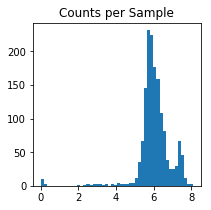

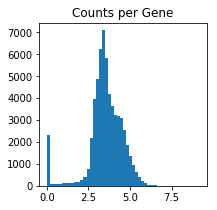

In [4]:
plt.figure(figsize=(3,3))
plt.hist(np.log10(bigframe.sum() + 1), bins=50)  # sum per sample
plt.title("Counts per Sample")
plt.savefig('/data/katrina/AutoEncode/tybalt/PDFS/vae_genecounts_per_sample.pdf')
plt.show()

plt.figure(figsize=(3,3))
plt.hist(np.log10(bigframe.sum(axis=1) + 1), bins=50)  # sum per gene
plt.title("Counts per Gene")
plt.savefig('/data/katrina/AutoEncode/tybalt/PDFS/vae_counts_per_gene.pdf')
plt.show()

### Generate Microbial Counts

In [5]:
def compute_microbe_walk(filename):
    '''Function to calculate genus, family, and category-level sums of NT_rpm from IDseq output'''
    
    # read in the file
    df = pd.read_csv(filename) 

    # remove species-level hits, because genus rows already have sum values
    df = df[df.tax_level != 1]   
    # remove rows with NT_rpm == 0 since they will contribute nothing to the total scores
    df = df[df.NT_rpm > 0]         


    #
    # generate the genus-level sum counts
    #
    genus_sums = df[['name','tax_id','NT_rpm']]
    # remove rows with genus_taxid == 0, because these may actually be family level hits
    genus_sums = genus_sums[genus_sums.tax_id > 0]
    genus_sums = genus_sums[['tax_id','NT_rpm']]

    #
    # generate the family sums using GROUP BY on the original matrix
    #
    family_values = df.groupby('family_taxid').sum()['NT_rpm']
    df2 = df.groupby('family_taxid').first()
    df3 = pd.concat([df2,family_values], axis=1)
    df4 = df3[['name','tax_id','category_name','NT_rpm']]
    df4.columns = ['name','tax_id','category_name','NT_rpm','NT_rpm_sum']
    family_sums = df4[['name','tax_id','category_name','NT_rpm_sum']]
    family_sums['family_taxid'] = family_sums.index
    # remove rows where family tax_id is < 0 - these aren't true family tax ids
    family_sums = family_sums[family_sums.family_taxid > 0]
    family_sums = family_sums[['family_taxid','NT_rpm_sum']]
    family_sums.columns = ['tax_id','NT_rpm']

    #
    # sum together all values from each category - virus, bacteria, eukaryote, archaea
    #
    df5 = df4.groupby('category_name').sum()['NT_rpm_sum']
    df6 = pd.DataFrame(df5)
    df6['tax_id'] = None
    df6['name'] = df5.index
    df6 = df6[['name','NT_rpm_sum']]
    df6.columns = ['tax_id', 'NT_rpm']

    #
    # concatonate the genus / family / category matrices together
    #
    final_microbe_df = pd.concat([genus_sums, family_sums, df6])
    final_microbe_df.reset_index(inplace=True, drop=True)
    #print(final_microbe_df['NT_rpm'].describe())
    final_microbe_df.sort_values(by='NT_rpm', ascending = False, inplace = True)
    final_microbe_df.index = list(final_microbe_df['tax_id'])
    final_microbe_df.drop('tax_id', axis=1, inplace = True)
    #final_microbe_df.head()
    
    return(final_microbe_df)

In [6]:
globbed_microbe_files = glob.glob('Data2/microbe*/*')
globbed_microbe_files

['Data2/microbe_vap/ops_005_vap_rna_9664_p1042495_s43.csv',
 'Data2/microbe_vap/vap3_rna_ta_0328_p1029727_s27.csv',
 'Data2/microbe_vap/vap_4_rna_ta_006078_p1036760_s29.csv',
 'Data2/microbe_vap/ops_005_vap_rna_11627_p1044409_s72.csv',
 'Data2/microbe_vap/ops_001_vap_rna_ta_9039_p1040356_s114.csv',
 'Data2/microbe_vap/vap8_rna_ta_006194_p1037879_s146.csv',
 'Data2/microbe_vap/ops_012_vap_ops_005repeat_ta_rna_9701_p1044541_m8_s76_l001.csv',
 'Data2/microbe_vap/ops_005_vap_rna_10921_p1042438_s18.csv',
 'Data2/microbe_vap/ops_006_vap_rna_ta_10138_p1043970_s134.csv',
 'Data2/microbe_vap/vap6_rna_ta_6317_p1038322_s134.csv',
 'Data2/microbe_vap/ops_007_vap_ta_rna_6397_p1038651_g2_s99_l002.csv',
 'Data2/microbe_vap/ops_005_vap_rna_9748_p1045702_s68.csv',
 'Data2/microbe_vap/ops_007_vap_ta_rna_5812_p1035754_f9_s25_l003.csv',
 'Data2/microbe_vap/ops_006_vap_rna_ta_10128_p1043986_s130.csv',
 'Data2/microbe_vap/ops_006_vap_rna_ta_007691_p1037256_s119.csv',
 'Data2/microbe_vap/ops_012_vap_ops_005r

In [7]:
data = []
names = []

names.append(globbed_microbe_files[0])
df1 = pd.DataFrame(compute_microbe_walk(globbed_microbe_files[0]))

names.append(globbed_microbe_files[1])
df2 = pd.DataFrame(compute_microbe_walk(globbed_microbe_files[1]))

df_curr = df1.join(df2, how = 'outer',lsuffix='_left', rsuffix='_right')
count = 2
success_parsing = False

# append gene values for all samples
for tsv in globbed_microbe_files[2:len(globbed_microbe_files)]:
    print(tsv)
    try:
        this_microbe = compute_microbe_walk(tsv)
        success_parsing = True
    except:
        print("Could not parse microbe file")
        
    if(success_parsing):
        count += 1
        names.append(tsv)
        df_temp = df_curr.join(pd.DataFrame(this_microbe), how = 'outer')
        df_temp.columns = [i for i in range(count)]
        df_curr = df_temp
        success_parsing = False

Data2/microbe_vap/vap_4_rna_ta_006078_p1036760_s29.csv


/data/katrina/anaconda3/envs/tybalt/lib/python3.5/site-packages/pandas/core/reshape/merge.py:736: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  sort=self.sort)


Data2/microbe_vap/ops_005_vap_rna_11627_p1044409_s72.csv
Data2/microbe_vap/ops_001_vap_rna_ta_9039_p1040356_s114.csv
Data2/microbe_vap/vap8_rna_ta_006194_p1037879_s146.csv
Data2/microbe_vap/ops_012_vap_ops_005repeat_ta_rna_9701_p1044541_m8_s76_l001.csv
Data2/microbe_vap/ops_005_vap_rna_10921_p1042438_s18.csv
Data2/microbe_vap/ops_006_vap_rna_ta_10138_p1043970_s134.csv
Data2/microbe_vap/vap6_rna_ta_6317_p1038322_s134.csv
Data2/microbe_vap/ops_007_vap_ta_rna_6397_p1038651_g2_s99_l002.csv
Data2/microbe_vap/ops_005_vap_rna_9748_p1045702_s68.csv
Data2/microbe_vap/ops_007_vap_ta_rna_5812_p1035754_f9_s25_l003.csv
Data2/microbe_vap/ops_006_vap_rna_ta_10128_p1043986_s130.csv


/data/katrina/anaconda3/envs/tybalt/lib/python3.5/site-packages/pandas/core/reshape/merge.py:736: RuntimeWarning: unorderable types: str() > int(), sort order is undefined for incomparable objects
  sort=self.sort)


Data2/microbe_vap/ops_006_vap_rna_ta_007691_p1037256_s119.csv
Data2/microbe_vap/ops_012_vap_ops_005repeat_ta_rna_7763_p1038002_g24_s48_l001.csv
Data2/microbe_vap/ops_005_vap_rna_2054_p1036288_s56.csv
Data2/microbe_vap/ops_001_vap_rna_ta_7419_p1036934_s141.csv


/data/katrina/anaconda3/envs/tybalt/lib/python3.5/site-packages/pandas/core/reshape/merge.py:736: RuntimeWarning: unorderable types: int() > str(), sort order is undefined for incomparable objects
  sort=self.sort)


Data2/microbe_vap/vap5_rna_ta_6044_p1037062_s52.csv
Data2/microbe_vap/vap_7_rna_ta_006391_p1038460_s78.csv
Data2/microbe_vap/ops_006_vap_rna_ta_014339_p1045823_s106.csv
Data2/microbe_vap/ops_007_vap_ta_rna_6420_p1038651_k2_s101_l002.csv
Data2/microbe_vap/vap9_rna_ta_006778_p1039086_s41.csv
Data2/microbe_vap/ops_007_vap_ta_rna_5433_p1046750_a20_s168_l002.csv
Data2/microbe_vap/vap9_rna_ta_008547_p1038923_s48.csv
Data2/microbe_vap/ops_007_vap_ta_rna_10513_p1043866_l1_s196_l003.csv
Data2/microbe_vap/ops_007_vap_ta_rna_13431_p1049867_k4_s109_l002.csv
Data2/microbe_vap/vap8_rna_ta_006171_p1037879_s144.csv
Data2/microbe_vap/ops_007_vap_ta_rna_2361_p1040459_p15_s54_l003.csv
Data2/microbe_vap/vap8_rna_ta_006180_p1037914_s150.csv
Data2/microbe_vap/ops_003_vap_rna_ta_4656_p1039141_s167.csv
Data2/microbe_vap/ops_007_vap_ta_rna_7680_p1036421_d15_s48_l003.csv
Data2/microbe_vap/ops_007_vap_ta_rna_14592_p1049992_f3_s1_l003.csv
Data2/microbe_vap/ops_005_vap_rna_10765_p1041537_s5.csv
Data2/microbe_vap/v

Data2/microbe_vap/vap5_rna_ta_6559_p1039105_s82.csv
Data2/microbe_vap/vap1_rna_ta_585_p1030415_s1.csv
Data2/microbe_vap/vap9_rna_ta_007059_p1043274_s38.csv
Data2/microbe_vap/vap8_rna_ta_006193_p1037879_s147.csv
Data2/microbe_vap/ops_006_vap_rna_ta_14318_p1045615_s123.csv
Data2/microbe_vap/ops_007_vap_ta_rna_3928_p1034031_l17_s60_l003.csv
Data2/microbe_vap/ops_012_vap_ops_005repeat_ta_rna_9744_p1045701_a18_s9_l001.csv
Data2/microbe_vap/ops_012_vap_ops_005repeat_ta_rna_11109_p1043095_k6_s63_l001.csv
Data2/microbe_vap/ops_007_vap_ta_rna_9852_p1049075_a24_s184_l002.csv
Data2/microbe_vap/vap5_rna_ta_6430_p1039105_s78.csv
Data2/microbe_vap/ops_007_vap_ta_rna_9848_p1048961_i22_s180_l002.csv
Data2/microbe_vap/ops_006_vap_rna_ta_12171_p1045787_s179.csv
Data2/microbe_vap/ops_005_vap_rna_9064_p1040486_s77.csv
Data2/microbe_vap/vap6_rna_ta_10379_p1042795_s100.csv
Data2/microbe_vap/ops_001_vap_rna_ta_8205_p1037465_s128.csv
Data2/microbe_vap/vap9_rna_ta_006967_p1042390_s28.csv
Data2/microbe_vap/ops_

Data2/microbe_vap/ops_005_vap_rna_7925_p1039178_s32.csv
Data2/microbe_vap/vap3_rna_ta_1009_p1027440_s7.csv
Data2/microbe_vap/vap9_rna_ta_007088_p1044399_s45.csv
Data2/microbe_vap/ops_007_vap_ta_rna_5169_p1044647_e22_s178_l002.csv
Data2/microbe_vap/ops_007_vap_ta_rna_12206_p1047479_e18_s162_l002.csv
Data2/microbe_vap/ops_012_vap_ops_005repeat_ta_rna_11627_p1044409_o18_s93_l001.csv
Data2/microbe_vap/ops_012_vap_ops_005repeat_ta_rna_7802_p1038580_o22_s95_l001.csv
Data2/microbe_vap/ops_005_vap_rna_7884_p1038972_s84.csv
Data2/microbe_vap/ops_006_vap_rna_ta_14142_p1044594_s136.csv
Data2/microbe_vap/vap_4_rna_ta_003553_p1031610_s3.csv
Data2/microbe_vap/ops_007_vap_ta_rna_15545_p1049718_m10_s134_l002.csv
Data2/microbe_vap/ops_012_vap_ops_005repeat_ta_rna_9732_p1045339_i16_s56_l001.csv
Data2/microbe_vap/ops_001_vap_rna_ta_7181_p1036793_s134.csv
Data2/microbe_vap/ops_003_vap_rna_ta_4614_p1039038_s163.csv
Data2/microbe_vap/ops_007_vap_ta_rna_5502_p1047727_e20_s170_l002.csv
Data2/microbe_vap/vap8_

Data2/microbe_vap/vap8_rna_ta_002013_p1035513_s182.csv
Data2/microbe_vap/ops_003_vap_rna_ta_4829_p1039812_s179.csv
Data2/microbe_vap/vap_7_rna_ta_006348_p1038459_s68.csv
Data2/microbe_vap/ops_007_vap_ta_rna_5238_p1045486_a10_s128_l002.csv
Data2/microbe_vap/ops_012_vap_ops_005repeat_ta_rna_10775_p1041588_g6_s39_l001.csv
Data2/microbe_vap/vap3_rna_ta_1002_p1026035_s2.csv
Data2/microbe_vap/vap9_rna_ta_008478_p1038618_s49.csv
Data2/microbe_vap/ops_005_vap_rna_9732_p1045339_s61.csv
Data2/microbe_vap/vap6_rna_ta_6127_p1037511_s105.csv
Data2/microbe_vap/ops_001_vap_rna_ta_8569_p1039191_s126.csv
Data2/microbe_vap/ops_006_vap_rna_ta_014266_p1045040_s115.csv
Data2/microbe_vap/vap9_rna_ta_006791_p1039321_s42.csv
Data2/microbe_vap/vap_4_rna_ta_002920_p1036560_s16.csv
Data2/microbe_vap/ops_007_vap_ta_rna_3843_p1033566_j21_s75_l003.csv
Data2/microbe_vap/ops_006_vap_rna_ta_014358_p1045823_s108.csv
Data2/microbe_vap/vap_7_rna_ta_006563_p1039933_s61.csv
Data2/microbe_vap/ops_007_vap_ta_rna_5468_p104755

Data2/microbe_vap/ops_006_vap_rna_ta_14240_p1045061_s121.csv
Data2/microbe_vap/vap_7_rna_ta_003969_p1034168_s57.csv
Data2/microbe_vap/ops_007_vap_ta_rna_5212_p1044722_e12_s138_l002.csv
Data2/microbe_vap/ops_001_vap_rna_ta_h20_p0_s144.csv
Data2/microbe_vap/vap_4_rna_ta_water-1_p_s38.csv
Data2/microbe_vap/ops_006_vap_rna_ta_14153_p1044594_s137.csv
Data2/microbe_vap/ops_007_vap_ta_rna_13182_p1047100_i4_s108_l002.csv
Data2/microbe_vap/vap1_rna_ta_3547_p1031604_s16.csv
Data2/microbe_vap/vap5_rna_ta_6523_p1039105_s76.csv
Data2/microbe_vap/ops_007_vap_ta_rna_7293_p1036103_j15_s51_l003.csv
Data2/microbe_vap/ops_007_vap_ta_rna_5629_p1034583_l11_s36_l003.csv
Data2/microbe_vap/ops_007_mmc74_bal_rna_waterb2_h10_s115_l003.csv
Data2/microbe_vap/ops_007_vap_ta_rna_8067_p1041586_g6_s115_l002.csv
Data2/microbe_vap/ops_007_vap_ta_rna_5693_p1034583_b13_s39_l003.csv
Data2/microbe_vap/vap5_rna_ta_10304_p1041478_s69.csv
Data2/microbe_vap/vap9_rna_ta_779_p1030846_re-prepvap1_s53.csv
Data2/microbe_vap/vap1_rn

Data2/microbe_vap/vap9_rna_ta_776_p1030846_re-prepvap1_s52.csv
Data2/microbe_vap/ops_007_vap_ta_rna_15462_p1048612_i14_s148_l002.csv
Data2/microbe_vap/vap1_rna_ta_3551_p1031604_s17.csv
Data2/microbe_vap/vap1_rna_ta_782_p1030933_s3.csv
Data2/microbe_vap/vap_7_rna_ta_010206_p1039933_s62.csv
Data2/microbe_vap/ops_006_vap_rna_ta_11301_p1045173_s151.csv
Data2/microbe_vap/ops_006_vap_rna_ta_014336_p1045823_s111.csv
Data2/microbe_vap/ops_003_vap_rna_ta_4795_p1039682_s183.csv
Data2/microbe_vap/ops_005_vap_rna_4260_p1038048_s91.csv
Data2/microbe_vap/vap1_rna_ta_water_p0_s25.csv
Data2/microbe_vap/ops_003_vap_rna_ta_10730_p1041101_s178.csv
Data2/microbe_vap/vap1_rna_ta_944_p1031376_s7.csv
Data2/microbe_vap/ops_001_vap_rna_ta_8105_p1038134_s118.csv
Data2/microbe_vap/vap8_rna_ta_010491_p1043449_s179.csv
Data2/microbe_vap/vap_7_rna_ta_012192_p1047409_s59.csv
Data2/microbe_vap/ops_006_vap_rna_ta_11329_p1045378_s158.csv
Data2/microbe_vap/ops_012_vap_ops_005repeat_ta_rna_7777_p1038512_c24_s24_l001.csv


Data2/microbe_vap/ops_007_vap_ta_rna_6259_p1038205_l7_s20_l003.csv
Data2/microbe_vap/ops_005_vap_rna_7777_p1038512_s90.csv
Data2/microbe_vap/ops_012_vap_ops_005repeat_ta_rna_7884_p1038972_g22_s47_l001.csv
Data2/microbe_vap/ops_006_vap_rna_ta_11537_p1046843_s154.csv
Data2/microbe_vap/ops_007_vap_ta_rna_6290_p1038352_f11_s33_l003.csv
Data2/microbe_vap/ops_012_vap_ops_005repeat_ta_rna_2054_p1036288_o14_s91_l001.csv
Data2/microbe_vap/vap3_rna_ta_0055_p1028941_s1.csv
Data2/microbe_vap/ops_005_vap_rna_7979_p1040296_s55.csv
Data2/microbe_vap/ops_012_vap_ops_005repeat_ta_rna_10700_p1040963_o2_s85_l001.csv
Data2/microbe_vap/vap_4_rna_ta_003581_p1031610_s4.csv
Data2/microbe_vap/ops_005_vap_rna_9683_p1043861_s47.csv
Data2/microbe_vap/vap5_rna_ta_10341_p1042678_s84.csv
Data2/microbe_vap/ops_007_vap_ta_rna_15623_p1049992_h5_s10_l003.csv
Data2/microbe_vap/vap6_rna_ta_5884_p1035971_s124.csv
Data2/microbe_vap/ops_007_vap_ta_rna_5633_p1034583_n11_s37_l003.csv
Data2/microbe_vap/ops_007_vap_ta_rna_watera

Data2/microbe_rapid-respose-rr007/chrf_rna_0056_s56.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0089_s89.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0020_s20.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0018_s18.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0047_s47.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0074_s74.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0008_s8.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0093_s93.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0013_s13.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0065_s65.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0082_s82.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0000_s97.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0064_s64.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0083_s83.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0075_s75.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0092_s92.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0012_s12.csv
Data2/microbe_rapid-respose-rr007/chrf_rna_0021_s

Data2/microbe_mbal_study_reports/mbal-357-dna-ta.csv
Data2/microbe_mbal_study_reports/mbal-241-dna-ta.csv
Data2/microbe_mbal_study_reports/mbal-232-dna-ta.csv
Data2/microbe_mbal_study_reports/mbal-212-rna-ta.csv
Data2/microbe_mbal_study_reports/mbal-257-dna-ta.csv
Data2/microbe_mbal_study_reports/mbal-261-rna-ta.csv
Data2/microbe_mbal_study_reports/mbal-208-dna-ta.csv
Data2/microbe_mbal_study_reports/mbal-272-rna-ta.csv
Data2/microbe_mbal_study_reports/mbal-237-dna-ta.csv
Data2/microbe_mbal_study_reports/mbal-221-dna-ta.csv
Data2/microbe_mbal_study_reports/mbal-264-rna-ta.csv
Data2/microbe_mbal_study_reports/mbal-252-dna-ta.csv
Data2/microbe_mbal_study_reports/mbal-217-rna-ta.csv
Data2/microbe_mbal_study_reports/mbal-298-dna-ta.csv
Data2/microbe_mbal_study_reports/mbal-268-dna-ta.csv
Data2/microbe_mbal_study_reports/mbal-368-dna-ta.csv
Data2/microbe_mbal_study_reports/mbal-301-rna-ta.csv
Data2/microbe_mbal_study_reports/mbal-337-dna-ta.csv
Data2/microbe_mbal_study_reports/mbal-317-rna-

Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1813_f1_s150.csv
Data2/microbe_ugd-hiv-pneu/ops017_ugd-hiv-pneu-dna-meera_ug3498b_d7_s131.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1563_m14_s108.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_2460_h8_s16.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1186_a4_s31.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1990_j11_s179.csv
Data2/microbe_ugd-hiv-pneu/ops017_ugd-hiv-pneu-dna-meera_ug4119b_h12_s176.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1266_g6_s68.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_2044_j13_s180.csv
Data2/microbe_ugd-hiv-pneu/ops017_ugd-hiv-pneu-dna-meera_ug3042b_h3_s167.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1216_k4_s91.csv
Data2/microbe_ugd-hiv-pneu/ops013_ugd-hiv-pneu-20161102_meera-dna_ug3305b_bal_c3_s13.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1477_m12_s107.csv
Data2/microbe_ugd-hiv-pneu/ops0

Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1242_a6_s32.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1488_o12_s119.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_2179_j19_s183.csv
Data2/microbe_ugd-hiv-pneu/ops017_ugd-hiv-pneu-dna-meera_ug3760b_c8_s122.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1446_g12_s71.csv
Data2/microbe_ugd-hiv-pneu/ops017_ugd-hiv-pneu-dna-meera_ug3938b_h5_s169.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1790_e24_s65.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1773_i22_s88.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1864_n3_s199.csv
Data2/microbe_ugd-hiv-pneu/ops017_ugd-hiv-pneu-dna-meera_ug3034b_e3_s137.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1978_b11_s131.csv
Data2/microbe_ugd-hiv-pneu/ops013_ugd-hiv-pneu-20161102_meera-dna_ug2979b_bal_b10_s10.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1142_c2_s42.csv
Data2/microbe_ugd-hiv-pneu/ops

Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1169_k2_s90.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1289_i6_s80.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_2321_j2_s17.csv
Data2/microbe_ugd-hiv-pneu/ops017_ugd-hiv-pneu-dna-meera_ug3237b_a6_s102.csv
Data2/microbe_ugd-hiv-pneu/ops017_ugd-hiv-pneu-dna-meera_ug4071b_d11_s135.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1428_m10_s106.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1628_c18_s50.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_2032_h13_s168.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1753_c22_s52.csv
Data2/microbe_ugd-hiv-pneu/ops013_ugd-hiv-pneu-20161102_meera-dna_ug3529b_bal_d5_s21.csv
Data2/microbe_ugd-hiv-pneu/ops017_ugd-hiv-pneu-dna-meera_ug4036b_g10_s164.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1254_e6_s56.csv
Data2/microbe_ugd-hiv-pneu/ops017_ugd-hiv-pneu-dna-meera_ug3748b_b8_s113.csv
Data2/microbe_ugd-hiv-pneu/

Data2/microbe_ugd-hiv-pneu/ops017_ugd-hiv-pneu-dna-meera_ug4111b_f12_s156.csv
Data2/microbe_ugd-hiv-pneu/ops017_ugd-hiv-pneu-dna-meera_ug3161b_h4_s168.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_2423_l6_s23.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1937_p7_s213.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1397_c10_s46.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1655_i18_s86.csv
Data2/microbe_ugd-hiv-pneu/ops017_ugd-hiv-pneu-dna-meera_ug4015b_h9_s173.csv
Data2/microbe_ugd-hiv-pneu/ops015_ugd-hiv-pneu_bal_rna_1243_c6_s44.csv


In [8]:
df_curr.columns = [i.split('/')[-1].split('.')[0].upper() for i in names]
print(df_curr.shape)
df_curr.head()

(12797, 1588)


,OPS_005_VAP_RNA_9664_P1042495_S43,VAP3_RNA_TA_0328_P1029727_S27,VAP_4_RNA_TA_006078_P1036760_S29,OPS_005_VAP_RNA_11627_P1044409_S72,OPS_001_VAP_RNA_TA_9039_P1040356_S114,VAP8_RNA_TA_006194_P1037879_S146,OPS_012_VAP_OPS_005REPEAT_TA_RNA_9701_P1044541_M8_S76_L001,OPS_005_VAP_RNA_10921_P1042438_S18,OPS_006_VAP_RNA_TA_10138_P1043970_S134,VAP6_RNA_TA_6317_P1038322_S134,...,OPS015_UGD-HIV-PNEU_BAL_RNA_2206_J21_S184,OPS017_UGD-HIV-PNEU-DNA-MEERA_UG3065B_B4_S109,OPS017_UGD-HIV-PNEU-DNA-MEERA_UG4111B_F12_S156,OPS017_UGD-HIV-PNEU-DNA-MEERA_UG3161B_H4_S168,OPS015_UGD-HIV-PNEU_BAL_RNA_2423_L6_S23,OPS015_UGD-HIV-PNEU_BAL_RNA_1937_P7_S213,OPS015_UGD-HIV-PNEU_BAL_RNA_1397_C10_S46,OPS015_UGD-HIV-PNEU_BAL_RNA_1655_I18_S86,OPS017_UGD-HIV-PNEU-DNA-MEERA_UG4015B_H9_S173,OPS015_UGD-HIV-PNEU_BAL_RNA_1243_C6_S44
Bacteria,11.664,2815.981,452.713,75.966,1270.493,15.388,3791.041,29.907,355.983,156.982,...,75.501,1.681,46.496,6.649,28.192,2836.207,1646.302,2308.421,327.255,6577.999
171552,3.399,219.371,0.067,NaN,104.107,0.054,40.822,0.549,NaN,7.614,...,0.175,0.047,10.325,0.023,NaN,0.238,0.045,1.169,186.764,NaN
838,3.349,218.430,0.067,NaN,77.112,0.054,40.822,0.549,NaN,7.614,...,0.175,0.047,10.325,0.023,NaN,0.238,0.045,1.002,186.764,NaN
1300,0.391,1422.304,NaN,0.083,179.040,3.025,7.069,1.013,0.279,16.820,...,25.300,0.648,20.740,1.223,19.977,1.428,0.079,3.675,26.783,4.591
1301,0.391,1422.256,NaN,0.083,179.040,3.025,7.069,1.013,0.279,16.820,...,25.300,0.648,20.740,1.223,19.977,1.428,0.079,3.508,26.783,4.217


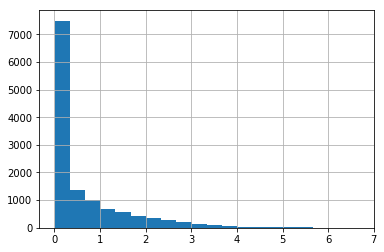

In [9]:
np.log10(df_curr.sum(axis=1) + 1).hist(bins=20)

In [10]:
df_curr.to_csv("Data2/concatonated_microbecounts.csv")